# Project: Stock Price Prediction

In [141]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

### Overall Goal

Predict stock price (high) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [127]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)
df = df.iloc[::-1] #reverse df order

df.head()

,Date,Close/Last,Open,High,Low
2530,02/24/2014,1847.61,1836.78,1858.71,1836.78
2529,02/25/2014,1845.12,1847.66,1852.91,1840.19
2528,02/26/2014,1845.16,1845.79,1852.65,1840.66
2527,02/27/2014,1854.29,1844.90,1854.53,1841.13
2526,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [128]:
def plot_chart(df, col): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        ax.plot(df['Date'], df[col[ind]])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

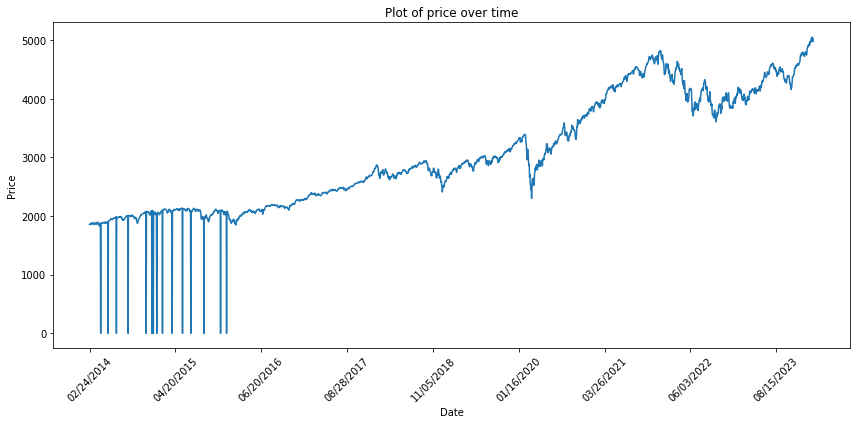

In [129]:
plot_chart(df, ["High"])

In [130]:
#remove data before june 2016
df['Date'] = pd.to_datetime(df['Date'])
df_filtered = df[df['Date'] >= '05/31/2016']

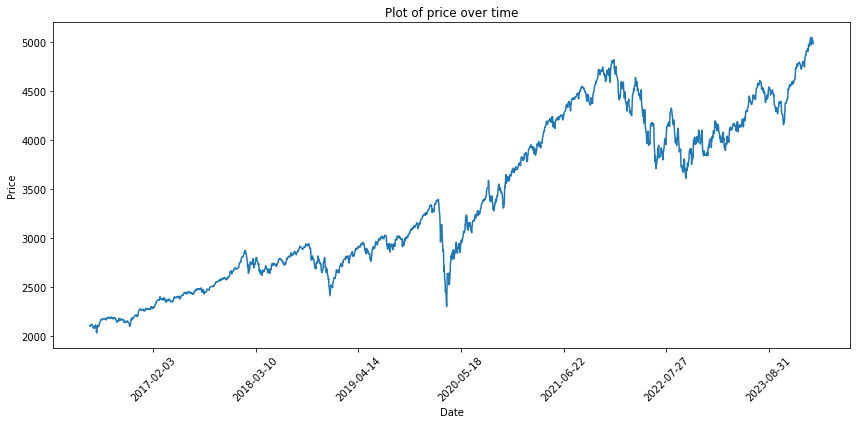

In [131]:
plot_chart(df_filtered, ["High"])

### 1. Linear Regression

In [132]:
#Technique 1: Linear Regression
#fit model to the last X (Hyperparam) days
#use model to predict price on day X+1
#eval

In [136]:
#fit model

def fit_lin_reg(X):
    model = LinearRegression()

    stock_prices = df_filtered["High"].values
    predicted_stock_prices = [0] * X

    for ind, _ in enumerate(stock_prices): #loop over daily highs
        if ind >= len(stock_prices) - X:
            break
        prices = stock_prices[ind:ind + X] #get X highs (label)
        days = np.arange(X).reshape(-1, 1) #X days (feature)
        model.fit(days, prices) #fit model to training examples
        y_pred = model.predict(np.array(X + 1).reshape(-1, 1)) #predict on day X+1
        predicted_stock_prices.append(round(y_pred[0], 2)) 

    predicted_stock_prices = np.array(predicted_stock_prices)
    df_filtered_ext = df_filtered.copy()
    df_filtered_ext["lin_reg_pred"] = predicted_stock_prices
    return df_filtered_ext

df_filtered_ext = fit_lin_reg(50)

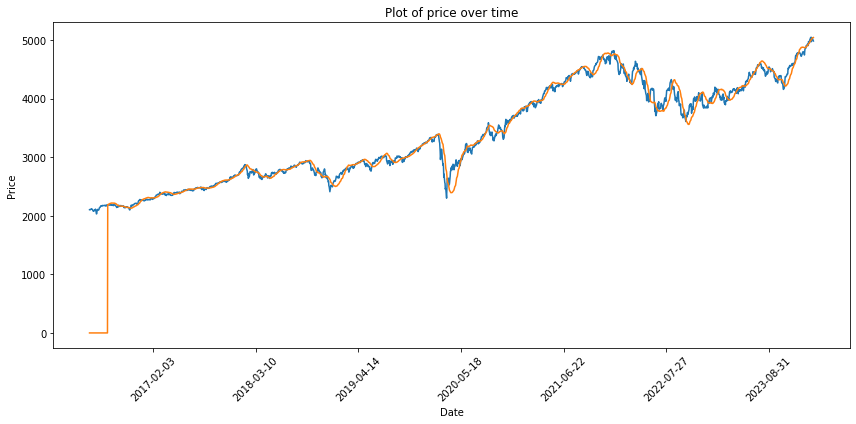

In [137]:
#plot
plot_chart(df_filtered_ext, ["High", "lin_reg_pred"])

In [160]:
#eval

#print(df_filtered_ext["High"][X:])
#print(df_filtered_ext["lin_reg_pred"][X:])
errors = []

for X in tqdm(range(1,20)):
    df_filtered_ext = fit_lin_reg(X)
    mse = np.mean((df_filtered_ext["High"][X:] - df_filtered_ext["lin_reg_pred"][X:]) ** 2)
    errors.append(mse)

100%|██████████| 19/19 [00:22<00:00,  1.18s/it]


Lowest MSE is 960.2834213477364, with X=1 (just copies high from prev day)
Lowest MSE is 2471.4208342444563, with non-trivial X=5


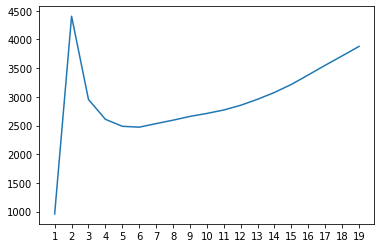

In [168]:
x_values = np.arange(1, len(errors) + 1)
plt.plot(x_values, errors)
plt.xticks(np.arange(1, len(errors) + 1, 1))

best_X, best_MSE = min(enumerate(errors), key=lambda x: x[1])
print(f"Lowest MSE is {best_MSE}, with X={best_X+1} (just copies high from prev day)")

errors_copy = errors.copy()

del errors_copy[best_X]

sec_best_X, sec_best_MSE = min(enumerate(errors_copy), key=lambda x: x[1])
print(f"Lowest MSE is {sec_best_MSE}, with non-trivial X={sec_best_X+1}")

Can I find a method that is better than just copying the value from the previous day?